### Descrição do problema - Kaggle

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

The train and test data are randomly split. 

O objetivo deste projeto é determinar o destino de animais que chegam em abrigos nos EUA.

As previsões feitas com o modelo criado aqui atingiram um score de 0.80296 no Kaggle.

### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

### Importação dos dados

In [2]:
raw_data=pd.read_csv('train.csv')

In [3]:
raw_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
df=raw_data.copy()
df.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

### Tratamento das variáveis categóricas

Inicialmente vamos tratar a variável AgeuponOutcome. Todos os valores serão convertidos para anos.

In [5]:
# Identificar o número e se ele está em dias, anos, semanas, meses ou anos.

ages=[]

for n in range(len(df)):
    value=str(df['AgeuponOutcome'][n])
    age = float(value.split()[0])
    if value.find('year') != -1:
        ages.append(age)
    elif value.find('month') != -1:
        ages.append(age/12)
    elif value.find('week') != -1:
        ages.append(age/52)     
    elif value.find('day') != -1:
        ages.append(age/365)
    else:     
        ages.append(0)
        
df['AgeInYears']=ages 

A seguir, trataremos a variável SexuponOutcome como no caso anterior. Contudo, criaremos duas colunas, uma para indicar o sexo e outra para indicar se o animal é castrado: Male/Female e (Neutered/Spayed)/Intact

In [6]:
gender=[]
condition=[]

for n in range(len(df)):
    value=str(df['SexuponOutcome'][n])
    if value.find('Neutered') != -1 or value.find('Spayed') != -1 and value.find('Male') != -1:
        gender.append('Male')
        condition.append('Neutered')
    elif value.find('Neutered') != -1 or value.find('Spayed') != -1 and value.find('Female') != -1:
        gender.append('Female')
        condition.append('Neutered')
    elif value.find('Intact') != -1 and value.find('Male') != -1:
        gender.append('Male')
        condition.append('Intact')
    elif value.find('Intact') != -1 and value.find('Female') != -1:
        gender.append('Female')
        condition.append('Intact')    
    else:     
        gender.append('Unknown')
        condition.append('Unknown')
        
df['Gender']=gender
df['Condition']=condition

Para tratar a coluna Breed, vamos definir apenas raças puras ou cães SRD, ou seja mix.

In [7]:
breed=[]

for n in range(len(df)):
    value=str(df['Breed'][n])
    if value.find('Mix') != -1 or value.find('/') != -1:
        breed.append('Mix')   
    else:     
        breed.append(value)
        
df['Breeds']=breed

Para tratar a coluna Color, vamos considerar cães com mais de uma cor como mix e cães com cores únicas.

In [8]:
color=[]

for n in range(len(df)):
    value=str(df['Color'][n])
    if value.find('and') != -1 or value.find('/') != -1:
        color.append('Mix')   
    else:     
        color.append(value)
        
df['Colors']=color

A seguir, vamos separar a informação contida na coluna Breed em duas novas colunas. O objetivo desta manipulação é analisar e calssificar quais raças apresentam agressividade ou problemas comportamentais.

In [9]:
# Criaremos duas colunas, uma para cada raça da coluna Breed.  
breed1=[]
breed2=[]
mix=[]
for n  in range(len(df)):
    value=str(df['Breed'][n])
    if value.find('/') != -1:
        breed1.append(df['Breed'][n].split('/')[0])
        breed2.append(df['Breed'][n].split('/')[1])
    elif value.find('Mix') != -1:
        breed1.append(df['Breed'][n].split('Mix')[0])
        breed2.append('Mix')
    else:
        breed1.append(value)
        breed2.append("")
df['Breed_1']=breed1 
df['Breed_2']=breed2        

In [10]:
# Criaremos uma lista que armazenará as raças que apresentaram problemas de agressividade e outra para problemas
# comportamentais
agressivo=[]
for n  in range(len(df)):
    if df['OutcomeSubtype'][n]=='Aggressive' and df['Breed_1'][n]!='Mix' and df['Breed_1'][n] not in agressivo:
        agressivo.append(str(df['Breed_1'][n]))
        if df['Breed_2'][n]!='Mix' and df['Breed_2'][n] not in agressivo:
            agressivo.append(str(df['Breed_2'][n]))

comportamento=[]
for n  in range(len(df)):
    if df['OutcomeSubtype'][n]=='Behavior' and df['Breed_1'][n]!='Mix' and df['Breed_1'][n] not in comportamento:
        comportamento.append(str(df['Breed_1'][n]))
        if df['Breed_2'][n]!='Mix' and df['Breed_2'][n] not in comportamento:
            comportamento.append(str(df['Breed_2'][n]))            
        

In [11]:
# Buscaremos para cada raça no nosso dataset se a raça apresenta ou não problemas de agressividade ou comportamental
# se a raça estiver na lista criada anteriormente, 
#classificaremos o animal com possível problema de agressividade ou comportamental

agressividade=[]
for n in range(len(df)):
    if df['Breed_1'][n]  in agressivo or df['Breed_2'][n]  in agressivo:
        agressividade.append(1)
    else:
        agressividade.append(0)
        
comportamental=[]
for n in range(len(df)):
    if df['Breed_1'][n]  in comportamento or df['Breed_2'][n]  in comportamento:
        comportamental.append(1)
    else:
        comportamental.append(0)        
        
df['Agressivo']=agressividade 
df['Comportamental']=comportamental         

### Tratamento das variáveis datetime

Agora trataremos a coluna DateTime. Vamos separar em colunas diferentes que contém a data, mês, dia da semana e a hora do dia.

In [12]:
datetime=pd.to_datetime(pd.Series(df['DateTime']))
df['year']=datetime.dt.year
df['month']=datetime.dt.month
df['day_week']=datetime.dt.day_name()
df['hour']=datetime.dt.hour

In [13]:
# Criaremos uma coluna para cada intervalo de horários, com início as 8 da manhã e duração de 3 horas.

horario=[]

for n in range(len(df)):
    i=df['hour'][n]
    if 8<=i<=10:
        horario.append(1)
    elif 11<=i<=13:
        horario.append(2)
    elif 14<=i<=16:
        horario.append(3)
    elif 16<=i<=18:
        horario.append(4)
    else:
        horario.append(5)
df['horario']=horario        

In [14]:
# Criaremos colunas para indicar a estação do ano e período de férias (do calendário americano).
estacao=[]
ferias=[]
weekend=[]

for n in range(len(df)):
    i=df['month'][n]
    if 6<=i<=8 or i==12 or i==11:
        ferias.append(1)
    else:
        ferias.append(0)
        
        
for n in range(len(df)):
    i=df['month'][n]
    if 3<=i<=6:
        estacao.append(1)
    elif 7<=i<=9:
        estacao.append(2)
    elif 9<=i<=12:
        estacao.append(3)
    elif 1<=i<=3:
        estacao.append(4)
# Criaremos uma coluna para indicar se é fim de semana

for n in range(len(df)):
    i=df['day_week'][n]
    if i=='Sunday' or i=='Saturday':
        weekend.append(1)
    else:
        weekend.append(0)        
        
df['weekend']=weekend        
df['estacao']=estacao 
df['hollidays']=ferias

In [15]:
# Removeremos as variáveis que não serão mais utilizadas
df=df.drop(['AnimalID','Name','Color','DateTime','Colors','Breeds',
            'AgeuponOutcome','SexuponOutcome','Breed','Breed_1','Breed_2'],1)

Utilizaremos a partir de agora o dataframe data.

In [16]:
data=df.copy()

### Análise Exploratória

Vamos iniciar uma análise exploratória geral nos nossos dados.

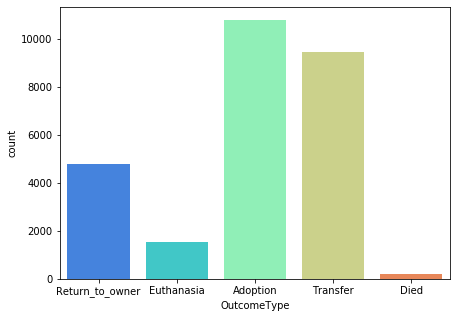

In [17]:
plt.figure(figsize=(7,5))
sns.countplot(df['OutcomeType'], palette='rainbow')

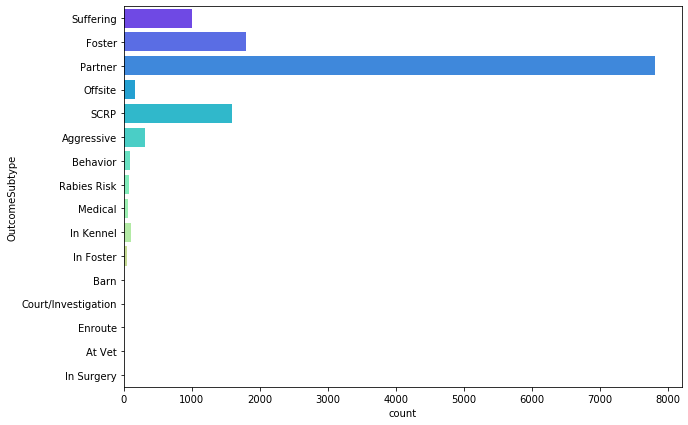

In [18]:
plt.figure(figsize=(10,7))
sns.countplot(y=df['OutcomeSubtype'], palette='rainbow')

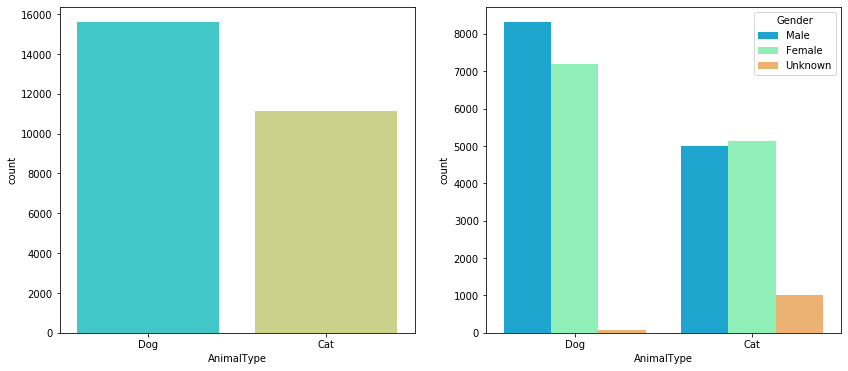

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.countplot(df['AnimalType'], palette='rainbow',ax = ax[0])
   
sns.countplot(df['AnimalType'],hue=df['Gender'], palette='rainbow',ax = ax[1])


In [20]:
len(df[df['AnimalType']=='Dog'])*100/len(df),len(df[df['AnimalType']=='Cat'])*100/len(df)

(58.34486886901867, 41.65513113098133)

A porcentagem de cães é de 58% e gatos de 42%. No gráfico da direita observamos os tipos de animais separados por sexo.

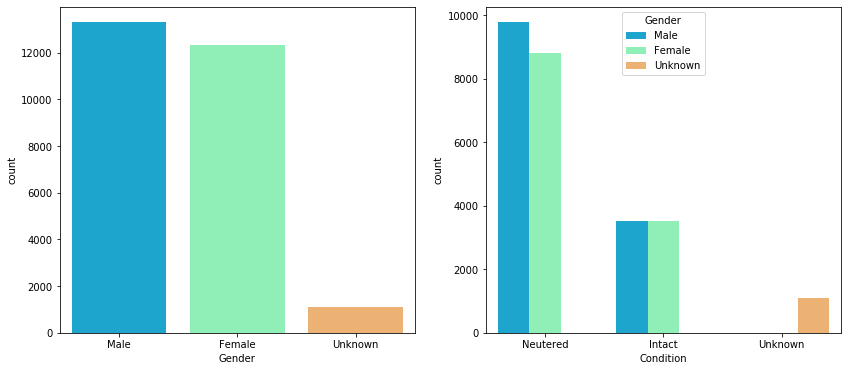

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.countplot(df['Gender'], palette='rainbow',ax = ax[0])
   
sns.countplot(df['Condition'], hue=df['Gender'], palette='rainbow',ax = ax[1])

In [22]:
len(df[df['Gender']=='Female'])*100/len(df),len(df[df['Gender']=='Male'])*100/len(df)

(46.13341314676943, 49.77365408357963)

A porcentagem de fêmeas é 46% e macho é 50%.

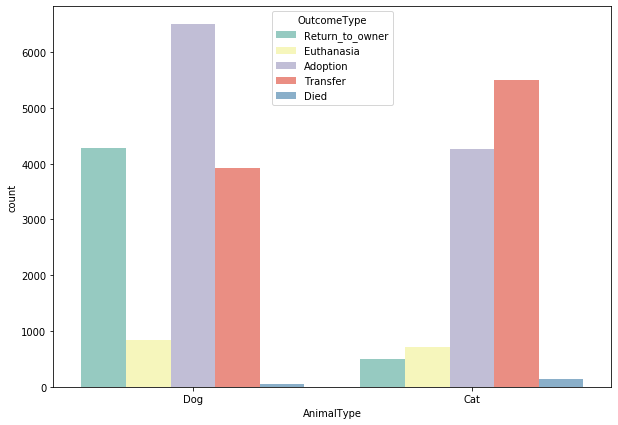

In [23]:
plt.figure(figsize=(10,7))
ax=sns.countplot(df['AnimalType'],hue=df['OutcomeType'], palette='Set3') 


In [24]:
print(str('Adoption'),len(df[(df['AnimalType']=='Dog')&(df['OutcomeType']=='Adoption')])*100/len(df),
      str('Return_to_owner'),len(df[(df['AnimalType']=='Dog')&(df['OutcomeType']=='Return_to_owner')])*100/len(df),
      str('Transfer'),len(df[(df['AnimalType']=='Dog')&(df['OutcomeType']=='Transfer')])*100/len(df),
      str('Euthanasia'),len(df[(df['AnimalType']=='Dog')&(df['OutcomeType']=='Euthanasia')])*100/len(df),
      str('Died'),len(df[(df['AnimalType']=='Dog')&(df['OutcomeType']=='Died')])*100/len(df)
     )

Adoption 24.306932545175652 Return_to_owner 16.03501814508586 Transfer 14.654495117662464 Euthanasia 3.1613603202514122 Died 0.18706274084327884


In [25]:
print(str('Adoption'),len(df[(df['AnimalType']=='Cat')&(df['OutcomeType']=='Adoption')])*100/len(df),
      str('Return_to_owner'),len(df[(df['AnimalType']=='Cat')&(df['OutcomeType']=='Return_to_owner')])*100/len(df),
      str('Transfer'),len(df[(df['AnimalType']=='Cat')&(df['OutcomeType']=='Transfer')])*100/len(df),
      str('Euthanasia'),len(df[(df['AnimalType']=='Cat')&(df['OutcomeType']=='Euthanasia')])*100/len(df),
      str('Died'),len(df[(df['AnimalType']=='Cat')&(df['OutcomeType']=='Died')])*100/len(df)
     )

Adoption 15.982640577649743 Return_to_owner 1.8706274084327883 Transfer 20.595607766845 Euthanasia 2.6562909199745595 Died 0.5499644580792398


O gráfico acima mostra os tipos de animais em função do que ocorreu com ele.
Observamos alguns pontos importantes:

- Porcentagem de adoção de cães é de 24% e dos gatos é de 16%
- Porcentagem de Eutanásia de cães é de 3% e dos gatos é de 3%
- Porcentagem de retorno aos donos de cães é de 16% e dos gatos é de 2% 
- Porcentagem de transferência de cães é de 15% e dos gatos é de 21%
- Porcentagem de mortes de cães é de 0.2% e dos gatos é de 0.5%

Ou seja, cães tem taxas maiores de adoção e de retorno aos donos. Já os gatos tem maiores chances de tranferência ou adoção.

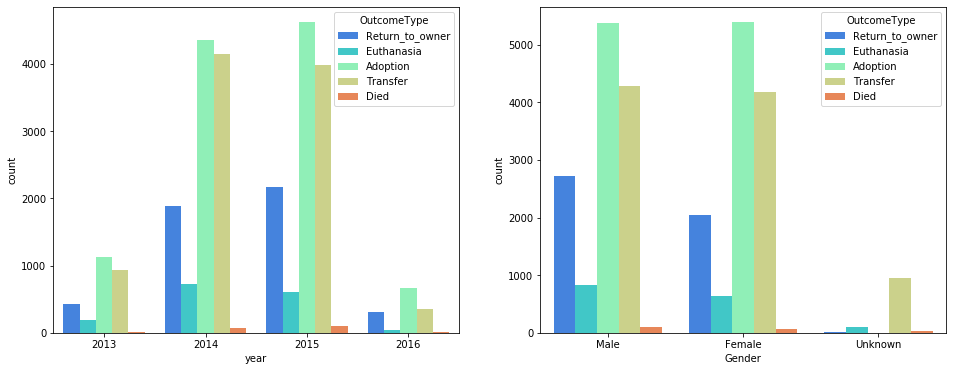

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

sns.countplot(df['year'],hue=df['OutcomeType'], palette='rainbow',ax = ax[0])
   
sns.countplot(df['Gender'], hue=df['OutcomeType'], palette='rainbow',ax = ax[1])

Observamos uma tendência de adoção nos anos de 2014 e 2015 que não continuou em 2016.

Ao analisar a taxa de outcomes em função do sexo, vemos que a maioria dos animais são Adotados, transferidos ou retornam aos seus donos.

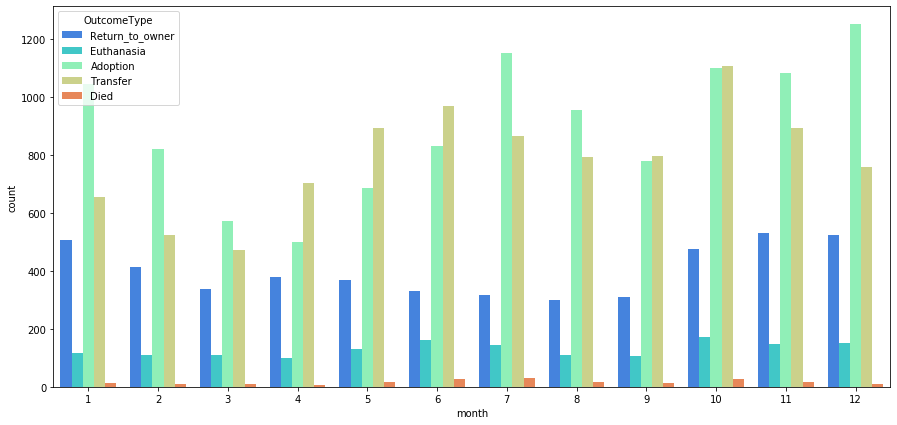

In [27]:
plt.figure(figsize=(15,7))
sns.countplot(df['month'],hue=df['OutcomeType'], palette='rainbow')

O mês de dezembro tem uma maior taxa de adoção e o mês de abril a taxa mais baixa.

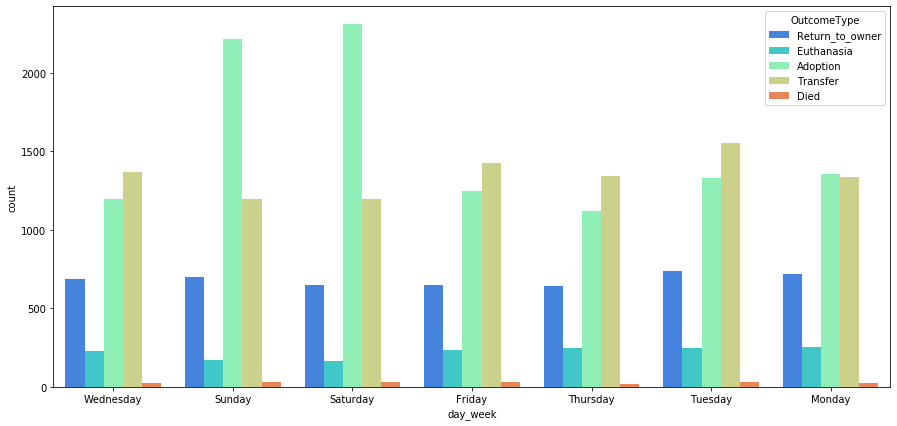

In [28]:
plt.figure(figsize=(15,7))
sns.countplot(df['day_week'],hue=df['OutcomeType'], palette='rainbow')

As adoções são mais comuns nos finais de semana.

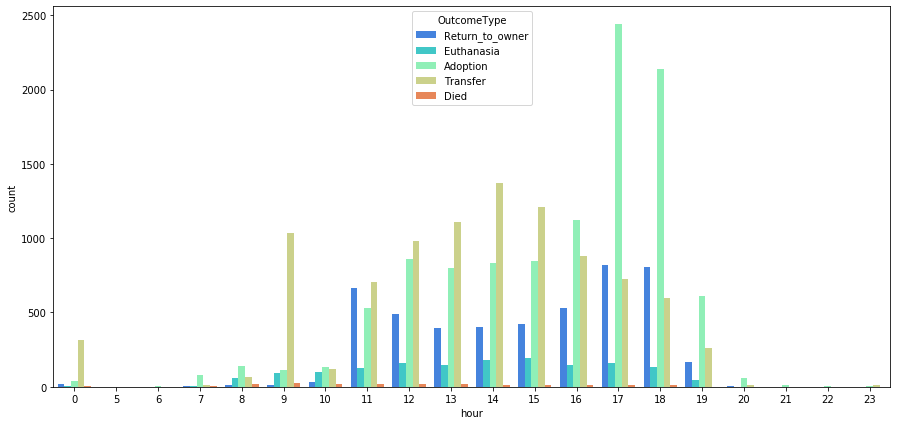

In [29]:
plt.figure(figsize=(15,7))
sns.countplot(df['hour'],hue=df['OutcomeType'], palette='rainbow')

Os horários em que mais acontecem adoções são entre 17-18h.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Text(0, 0.5, 'Counts')

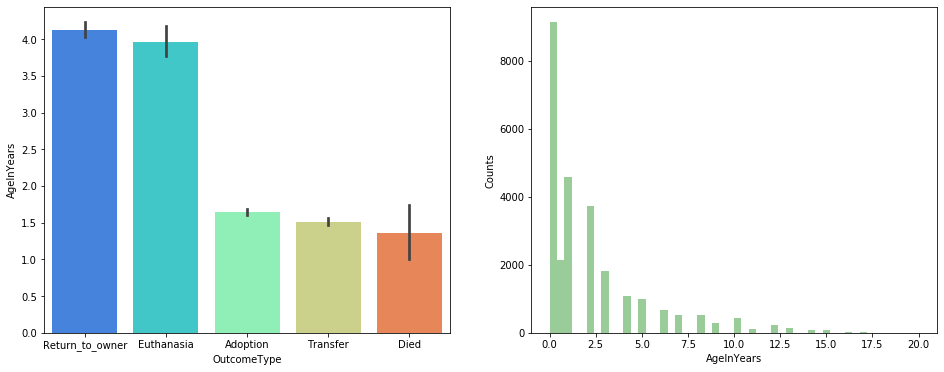

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
u=df[df['AgeInYears']!='Unknown']
sns.barplot(x = 'OutcomeType', y ='AgeInYears', data = u, palette="rainbow",ax = ax[0])
   
sns.distplot(u['AgeInYears'],color='green', kde=False,ax = ax[1])
ax[1].set_ylabel('Counts')

A maioria dos animais adotados têm até 1.5 ano de idade.


In [31]:
data=data.drop(['OutcomeSubtype','day_week','hour','month'],1)

### Encoding das variáveis categóricas

Antes de iniciar a criação dos modelos de predição, vamos criar encodings para as variáveis categóricas.
Nos testes, observamos que a eficiência do modelo melhora quando não fornecemos as variáveis Breed e Colors, portanto ela já foram removidas do dataset data.

In [32]:
le_outcome= preprocessing.LabelEncoder()
data['OutcomeType'] = le_outcome.fit_transform(data['OutcomeType'])

le_animal_type= preprocessing.LabelEncoder()
data['AnimalType'] = le_animal_type.fit_transform(data['AnimalType'])

le_gender= preprocessing.LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender'])

le_condition= preprocessing.LabelEncoder()
data['Condition'] = le_condition.fit_transform(data['Condition'])

le_year= preprocessing.LabelEncoder()
data['year'] = le_year.fit_transform(data['year'])


### Classificação por Kmeans clustering

Para tentar melhorar o modelo de classificação, vamos utilizar k means clustering para identificar grupos com características semelhantes no nosso dataset.

In [33]:
features=data.drop('OutcomeType',1)

Iremos achar o melhor valor de n_clustering pelo método do cotovelo e silhueta. 

In [34]:
# Para achar o n ótimo, precisamos calcular o wcss
def calculate_wcss(inp):
    wcss = []
    for n in range(1, 11):
        initial=inp.head(n)
        kmeans = KMeans(n_clusters=n)#init=initial,n_init=1)
        kmeans.fit(X=inp)
        wcss.append((n,kmeans.inertia_))
    wcss=pd.DataFrame(wcss)
    wcss.columns=['n','kmeans.inertia']        
    return wcss

# Como nem sempre é fácil identificar com o olho o melhor ponto, vamos utilizar uma função para isso

def calculate_sil(inp,kmax):
    sil = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(inp)
        labels = kmeans.labels_
        sil.append((k,silhouette_score(inp, labels, metric = 'euclidean')))
    sil=pd.DataFrame(sil)
    sil.columns=['n','sil']    
    return sil
    
def otimizar_cluster(wcss):
    wcss=wcss.values.tolist()
    x1, y1 = wcss[0][0], wcss[0][1]
    x2, y2 =  wcss[len(wcss)-1][0], wcss[len(wcss)-1][1]
    distances = []
    for i in range(len(wcss)):
        x0 = wcss[i][0]
        y0 = wcss[i][1]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)   
    return distances.index(max(distances))+1

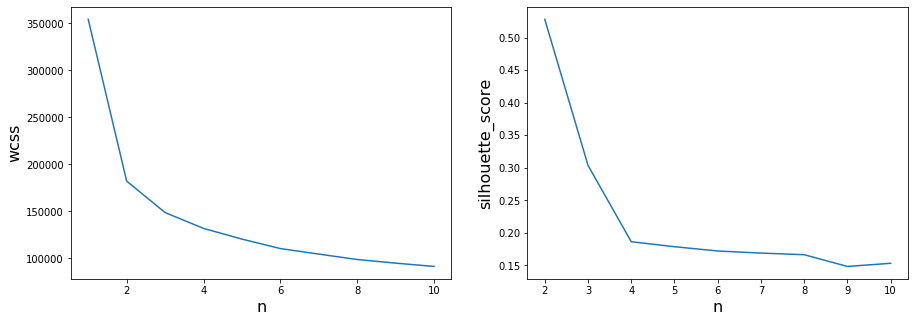

In [35]:
# Calcular os valores de wcss e do gráfico silhueta com as funções definidas acima
wcss=calculate_wcss(features)
sil=calculate_sil(features,10)

fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
ax1.plot(wcss['n'],wcss['kmeans.inertia'])
ax1.set_ylabel('wcss', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax2.plot(sil['n'], sil['sil'])
ax2.set_ylabel('silhouette_score', fontsize = 16)
ax2.set_xlabel('n', fontsize = 16)
plt.show()

No gráfico wcss x n não fica muito claro qual o valor de n, podemos utilizar o gráfico silhueta e achar o ponto mais alto facilmente. Também podemos usar a função que foi feita logo acima para calcular o valor ótimo de n:

In [36]:
k=otimizar_cluster(wcss)
k

3

In [37]:
# Kmeans clustering é aplicado no conjunto de dados após otimização do valor de n_clusters
kmeans = KMeans(n_clusters=k) 
kmeans.fit(features)
data['kmeans']=kmeans.labels_

In [38]:
# Definir os targets e desordenar o dataset
shuffled_data = shuffle(data)
y=shuffled_data['OutcomeType']
X=shuffled_data.drop('OutcomeType',1)
#Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
X_train

,AnimalType,AgeInYears,Gender,Condition,Agressivo,Comportamental,year,horario,weekend,estacao,hollidays,kmeans
13306,0,0.833333,0,0,1,0,2,1,0,1,0,1
14176,1,9.000000,0,1,0,0,2,3,1,3,1,2
1378,0,0.076923,1,0,1,1,1,2,0,1,1,1
7396,1,1.000000,0,1,1,1,2,3,0,4,0,1
17738,1,16.000000,1,1,1,0,2,3,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
15828,1,0.416667,0,1,1,1,2,4,0,4,0,1
15794,1,1.000000,1,1,0,0,2,4,0,3,1,1
8865,0,0.038462,0,0,0,0,1,4,1,2,1,1
1098,1,1.000000,1,1,0,0,1,3,0,4,0,1


### Modelagem

Nesta etapa, testaremos alguns modelos para definir qual classificará melhor nossos dados.

#### Random Forest Classifier

In [40]:
rfc = RandomForestClassifier(n_estimators=100,random_state=0,bootstrap=True,oob_score=True)
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)
print("Accuracy:", rfc.score(X_test, y_test))
print(classification_report(y_test,rfc_predictions))
print(confusion_matrix(y_test, rfc_predictions))

Accuracy: 0.6091782017707944
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      3221
           1       0.15      0.09      0.11        55
           2       0.25      0.16      0.20       451
           3       0.40      0.39      0.39      1452
           4       0.67      0.67      0.67      2840

    accuracy                           0.61      8019
   macro avg       0.43      0.41      0.41      8019
weighted avg       0.60      0.61      0.60      8019

[[2356    2   36  439  388]
 [   7    5    5    3   35]
 [  79    5   72   82  213]
 [ 550    0   57  562  283]
 [ 507   21  113  309 1890]]


In [41]:
print(log_loss(y_test, rfc.predict_proba(X_test)))

1.897837479291877


#### Gradient Boosting Classifier

In [42]:
gbc = GradientBoostingClassifier(max_features='sqrt',n_estimators=100)
gbc.fit(X_train,y_train)
gbc_predict=gbc.predict(X_test)
gbc.fit(X_train,y_train)
print("Accuracy:", gbc.score(X_test, y_test))
print(classification_report(y_test,gbc_predict))
print(confusion_matrix(y_test, gbc_predict))

Accuracy: 0.6625514403292181
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3221
           1       1.00      0.02      0.04        55
           2       0.44      0.12      0.19       451
           3       0.48      0.42      0.45      1452
           4       0.73      0.69      0.71      2840

    accuracy                           0.66      8019
   macro avg       0.67      0.42      0.43      8019
weighted avg       0.65      0.66      0.64      8019

[[2689    0    8  312  212]
 [   3    1    1    6   44]
 [  72    0   56   78  245]
 [ 585    0   29  616  222]
 [ 587    0   34  272 1947]]


In [43]:
print(log_loss(y_test, gbc.predict_proba(X_test)))

0.8306132234963112


#### XGBOOST

In [44]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
xb = xgb.XGBClassifier()
xb.fit(X_train, y_train) 
xb_predictions = xb.predict(X_test)
print("Accuracy:", xb.score(X_test, y_test))
print(classification_report(y_test,xb_predictions))
print(confusion_matrix(y_test, xb_predictions))

Accuracy: 0.6584362139917695
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      3221
           1       1.00      0.02      0.04        55
           2       0.45      0.08      0.14       451
           3       0.47      0.41      0.44      1452
           4       0.72      0.69      0.70      2840

    accuracy                           0.66      8019
   macro avg       0.67      0.41      0.41      8019
weighted avg       0.65      0.66      0.64      8019

[[2693    0    5  302  221]
 [   4    1    1    5   44]
 [  74    0   37   86  254]
 [ 603    0   17  598  234]
 [ 597    0   22  270 1951]]


In [45]:
print(log_loss(y_test, xb.predict_proba(X_test)))

0.8317373383082732


#### XGBOOST DMATRIX

In [46]:
D_train = xgb.DMatrix(X_train,y_train)
D_test = xgb.DMatrix(X_test)
num_round = 125

parameters = {'max_depth':5, 'eta':0.1, 'objective':'multi:softprob',
              'num_class':5,'eval_metric':'mlogloss','subsample':0.85}

dmatrix = xgb.train(parameters, D_train, num_round)

print(log_loss(y_test, dmatrix.predict(D_test)))

0.8104248466701838


Comparando os valores de log-loss, conseguimos uma melhora na predição dos nossos dados com o dmatrix. Portanto, ele será utilizado para gerar as previsões do dataset teste.

### importância das variáveis

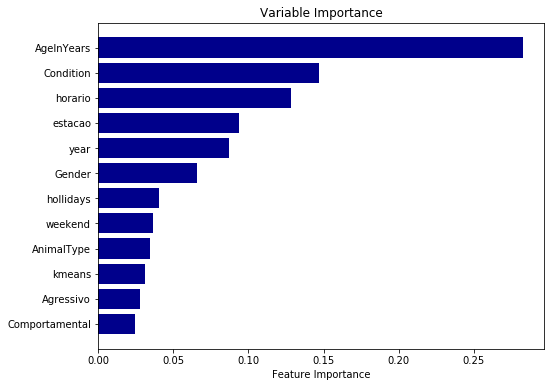

In [47]:
# Apenas para observar as variáveis que mais influênciam no destino dos animais de acordo com o modelo RFC

feature_importance = rfc.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='DarkBlue')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance')
plt.show()

Pelo ranking de importância das variáveis, vemos que as caracteristicas dos animais que mais influenciam no seu destino é a idade, se é castrado ou não, tipo e sexo do animal.

### Tratamento do arquivo test.csv

In [48]:
test_data=pd.read_csv('test.csv')
df=test_data.copy()

A seguir utilizando o dataset teste, faremos o mesmo tratamento que foi feito anteriormente.

In [49]:
ages=[]

for n in range(len(df)):
    value=str(df['AgeuponOutcome'][n])
    age = float(value.split()[0])
    if value.find('year') != -1:
        ages.append(age)
    elif value.find('month') != -1:
        ages.append(age/12)
    elif value.find('week') != -1:
        ages.append(age/52)     
    elif value.find('day') != -1:
        ages.append(age/365)
    else:     
        ages.append(0)
        
df['AgeInYears']=ages 

In [50]:
gender=[]
condition=[]

for n in range(len(df)):
    value=str(df['SexuponOutcome'][n])
    if value.find('Neutered') != -1 or value.find('Spayed') != -1 and value.find('Male') != -1:
        gender.append('Male')
        condition.append('Neutered')
    elif value.find('Neutered') != -1 or value.find('Spayed') != -1 and value.find('Female') != -1:
        gender.append('Female')
        condition.append('Neutered')
    elif value.find('Intact') != -1 and value.find('Male') != -1:
        gender.append('Male')
        condition.append('Intact')
    elif value.find('Intact') != -1 and value.find('Female') != -1:
        gender.append('Female')
        condition.append('Intact')    
    else:     
        gender.append('Unknown')
        condition.append('Unknown')
        
df['Gender']=gender
df['Condition']=condition

Para tratar a coluna Breed, vamos definir apenas raças puras ou cães SRD, ou seja mix.

In [51]:
breed=[]

for n in range(len(df)):
    value=str(df['Breed'][n])
    if value.find('Mix') != -1 or value.find('/') != -1:
        breed.append('Mix')   
    else:     
        breed.append(value)
        
df['Breeds']=breed

Para tratar a coluna Color, vamos considerar cães com mais de uma cor como mix e cães com cores únicas.

In [52]:
color=[]

for n in range(len(df)):
    value=str(df['Color'][n])
    if value.find('and') != -1 or value.find('/') != -1:
        color.append('Mix')   
    else:     
        color.append(value)
        
df['Colors']=color

A seguir, vamos separar a informação contida na coluna Breed em duas novas colunas. O objetivo desta manipulação é analisar e calssificar quais raças apresentam agressividade ou problemas comportamentais.

In [53]:
# Criaremos duas colunas, uma para cada raça da coluna Breed.  
breed1=[]
breed2=[]
mix=[]
for n  in range(len(df)):
    value=str(df['Breed'][n])
    if value.find('/') != -1:
        breed1.append(df['Breed'][n].split('/')[0])
        breed2.append(df['Breed'][n].split('/')[1])
    elif value.find('Mix') != -1:
        breed1.append(df['Breed'][n].split('Mix')[0])
        breed2.append('Mix')
    else:
        breed1.append(value)
        breed2.append("")
df['Breed_1']=breed1 
df['Breed_2']=breed2        

In [54]:
# Buscaremos para cada raça no nosso dataset se a raça apresenta ou não problemas de agressividade ou comportamental
# se a raça estiver na lista criada anteriormente, 
#classificaremos o animal com possível problema de agressividade ou comportamental

agressividade=[]
for n in range(len(df)):
    if df['Breed_1'][n]  in agressivo or df['Breed_2'][n]  in agressivo:
        agressividade.append(1)
    else:
        agressividade.append(0)
        
comportamental=[]
for n in range(len(df)):
    if df['Breed_1'][n]  in comportamento or df['Breed_2'][n]  in comportamento:
        comportamental.append(1)
    else:
        comportamental.append(0)        
        
df['Agressivo']=agressividade 
df['Comportamental']=comportamental         

In [55]:
datetime=pd.to_datetime(pd.Series(df['DateTime']))
df['year']=datetime.dt.year
df['month']=datetime.dt.month
df['day_week']=datetime.dt.day_name()
df['hour']=datetime.dt.hour

In [56]:
# Criaremos uma coluna para cada intervalo de horários, com início as 8 da manhã e duração de 3 horas.

horario=[]

for n in range(len(df)):
    i=df['hour'][n]
    if 8<=i<=10:
        horario.append(1)
    elif 11<=i<=13:
        horario.append(2)
    elif 14<=i<=16:
        horario.append(3)
    elif 16<=i<=18:
        horario.append(4)
    else:
        horario.append(5)
df['horario']=horario        

In [57]:
# Criaremos colunas para indicar a estação do ano e período de férias (do calendário americano).
estacao=[]
ferias=[]
weekend=[]

for n in range(len(df)):
    i=df['month'][n]
    if 6<=i<=8 or i==12 or i==11:
        ferias.append(1)
    else:
        ferias.append(0)
        
        
for n in range(len(df)):
    i=df['month'][n]
    if 3<=i<=6:
        estacao.append(1)
    elif 7<=i<=9:
        estacao.append(2)
    elif 9<=i<=12:
        estacao.append(3)
    elif 1<=i<=3:
        estacao.append(4)
# Criaremos uma coluna para indicar se é fim de semana

for n in range(len(df)):
    i=df['day_week'][n]
    if i=='Sunday' or i=='Saturday':
        weekend.append(1)
    else:
        weekend.append(0)        
        
df['weekend']=weekend        
df['estacao']=estacao 
df['hollidays']=ferias

In [58]:
df=df.drop(['ID','Name','Color','DateTime','Colors','Breeds','Breed_1','Breed_2',
            'AgeuponOutcome','SexuponOutcome','Breed','day_week','hour','month'],1)

data=df.copy()

le_animal_type= preprocessing.LabelEncoder()
data['AnimalType'] = le_animal_type.fit_transform(data['AnimalType'])

le_gender= preprocessing.LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender'])

le_condition= preprocessing.LabelEncoder()
data['Condition'] = le_condition.fit_transform(data['Condition'])

le_year= preprocessing.LabelEncoder()
data['year'] = le_year.fit_transform(data['year'])


In [59]:
# Kmeans clustering é aplicado no conjunto de dados após otimização do valor de n_clusters
kmeans = KMeans(n_clusters=k) 
kmeans.fit(data)
data['kmeans']=kmeans.labels_

In [60]:
X_test_new=data
D_test_new = xgb.DMatrix(X_test_new)

In [61]:
dmatrix_predictions=dmatrix.predict(D_test_new)
dmatrix_predictions

array([[1.5836129e-02, 2.9613953e-03, 4.9797926e-02, 2.4990964e-01,
        6.8149489e-01],
       [7.7343047e-01, 5.8654789e-04, 1.3921973e-02, 1.6214621e-01,
        4.9914803e-02],
       [3.4076056e-01, 3.4729922e-03, 1.3469227e-02, 1.2868212e-01,
        5.1361507e-01],
       ...,
       [4.4508078e-03, 5.4029995e-03, 4.6246663e-02, 3.1158545e-03,
        9.4078368e-01],
       [5.5365783e-01, 1.4415025e-03, 2.0238910e-02, 3.5645890e-01,
        6.8202808e-02],
       [6.7888983e-02, 1.7158244e-03, 4.3064487e-01, 3.5336208e-01,
        1.4638823e-01]], dtype=float32)

In [62]:
# Checar o índice de cada coluna antes de reagrupar

integer_mapping = {l: i for i, l in enumerate(le_outcome.classes_)}
integer_mapping

{'Adoption': 0,
 'Died': 1,
 'Euthanasia': 2,
 'Return_to_owner': 3,
 'Transfer': 4}

In [63]:
dmatrix_predictions=pd.DataFrame(dmatrix_predictions)


In [64]:
# Reagrupar os dados

predictions=pd.DataFrame()
predictions['ID']=test_data['ID']
predictions['Adoption']=dmatrix_predictions[0]
predictions['Died']=dmatrix_predictions[1]
predictions['Euthanasia']=dmatrix_predictions[2]
predictions['Return_to_owner']=dmatrix_predictions[3]
predictions['Transfer']=dmatrix_predictions[4]

predictions

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.015836,0.002961,0.049798,0.249910,0.681495
1,2,0.773430,0.000587,0.013922,0.162146,0.049915
2,3,0.340761,0.003473,0.013469,0.128682,0.513615
3,4,0.158596,0.005929,0.044753,0.081666,0.709056
4,5,0.503258,0.002180,0.008850,0.400571,0.085141
...,...,...,...,...,...,...
11451,11452,0.779768,0.001001,0.004277,0.009343,0.205610
11452,11453,0.000735,0.018902,0.020632,0.003601,0.956129
11453,11454,0.004451,0.005403,0.046247,0.003116,0.940784
11454,11455,0.553658,0.001442,0.020239,0.356459,0.068203


In [65]:
# Exportar o arquivo .csv

predictions.to_csv('predictions_dm.csv',index=False)
